In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
import torchvision.models as models




In [9]:
# loading the pretrained model of Vgg_16 which uses batch_normalization
net = models.vgg16_bn(pretrained=True)

# set the load_path for all image file
load_path = './images/'

# set the save_path for the extracted features file for all the classes
save_path = './Feature_extraction_2D/'
#os.mkdir(save_path)
os.makedirs(save_path, exist_ok=True)

# will get the names of the files present in the load path
# The training data
get_class_names = os.listdir(load_path)

# for each class file
get_class_names

['plane.npy', 'ship.npy', 'truck.npy', 'bird.npy', 'horse.npy']

In [11]:
for i in get_class_names:
    # To save the file with the same name for the extracted features
    new_save_path = save_path + i
    
    # To load the class file
    class_path = load_path + i

    # to load the numpy file
    img = np.load(class_path)

    # To append the extracted features
    arr = []

    # for each image in the class file
    for j in img:   

        # converting the numpy array to tensor
        j = torch.tensor(j)
        
        # reshaping the image to [batch_size,number_of_channel,height,width]
        j = j.view([-1,3,32,32])
        
        # rescaling the image to [1,3,224,224]
        # vgg_net the required input is of size 224*224 and single image so batch size 1 
        j = F.interpolate(j,(224,224))
        
        # Extracting the features from the middle layer of the network
        z = net.features(j)
        
        # Features extracted are of size [1,512,7,7]
        # Taking the average pooling for each channel
        m = F.avg_pool2d(z,(7,7),1,0)
        
        # Now the features are of size [1,512,1,1]
        #reshaping the features to [512] 
        m = m.view([-1]).detach()
        
        # converting it back to numpy array
        m = np.asarray(m)

        # appending to the arr
        arr.append(m)

    arr = np.asarray(arr)
    print(arr.shape)

    # To save the numpy array  
    np.save(new_save_path,arr)

(300, 512)
(300, 512)
(300, 512)
(300, 512)
(300, 512)


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle


# To set the load path for the extracted 2d features
# Change it to your team number
path = './Feature_extraction_2D/'
class_names = os.listdir(path)

print(class_names)

# val is to assign different labels to each class
val = 0
# To store all the data_points
data_points = []
# To store all the corresponding class values
data_points_class = []

# for each class
for i in class_names:
    
    # Load the corresponding class_file
    load_name = os.path.join(path,i)
    extracted_features = np.load(load_name)
    
    # for each data_point in the class
    for j in extracted_features:
        
        # store it in the array
        data_points.append(j)
        # store the corresponding the class value
        data_points_class.append(val)
    
    # The print is to show the corresponding class names and labels assigned to the class labels      
    # Note the corresponding labels and class assigned 
    print(val,i)
    val += 1


# the stored data points are in a sequence which can affect the model performance
# To randomlly shuffle the examples as to maintain the corresponding class label

temp = list(zip(data_points,data_points_class))
shuffle(temp)


data_points,data_points_class = zip(*temp)
data_points = np.asanyarray(data_points)
data_points_class = np.asanyarray(data_points_class)
# The final data_points in one array
print(data_points.shape)

['plane.npy', 'ship.npy', 'truck.npy', 'bird.npy', 'horse.npy']
0 plane.npy
1 ship.npy
2 truck.npy
3 bird.npy
4 horse.npy
(1500, 512)


In [431]:
dim_hidden_1 = 40
dim_hidden_2 = 28
pca_components = 10
C = 0.01

In [432]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_points, data_points_class,test_size = 0.2)

In [433]:
from sklearn import decomposition

pca1 = decomposition.PCA(n_components = pca_components)
pca1.fit(X_train)
X_train = pca1.transform(X_train)
print(X_train.shape)

pca2 = decomposition.PCA(n_components = pca_components)
pca2.fit(X_test)
X_test = pca2.transform(X_test)
print(X_test.shape)

(1200, 10)
(300, 10)


In [434]:
ytrain = Y_train
b = np.zeros((Y_train.size, Y_train.max()+1))
b[np.arange(Y_train.size),Y_train] = 1
Y_train=b
print(Y_train)

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [435]:
def relu(X):
   return np.maximum(0,X)
import math

def sigmoid(x):
  return 1/(1+np.exp(-x))

In [436]:
def initparameters():
  
 
  
    W1 = np.random.randn(dim_hidden_1,pca_components) * np.sqrt(2/pca_components)
    b1 = np.zeros(shape=(dim_hidden_1, 1))
    W2 = np.random.randn(dim_hidden_2, dim_hidden_1) * np.sqrt(2/dim_hidden_1)
    b2 = np.zeros(shape=(dim_hidden_2, 1))
    W3 = np.random.randn(5, dim_hidden_2) * np.sqrt(2/dim_hidden_2)
    b3 = np.zeros(shape=(5, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [437]:
# GRADED FUNCTION: compute_cost

def compute_cost(A3, Y, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    m=1200
    lam=0.4
    logprobs = np.multiply(np.log(A3), Y) + np.multiply((1 - Y), np.log(1 - A3))
    cost =( - np.sum(logprobs) / m)+(lam * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m))
    cost = float(np.squeeze(cost))
    
    return cost

In [438]:
def backward_propagation(parameters, cache, X, Y):
   
    m=1200
   
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
        
    
    A1 = cache['A1']
    A2 = cache['A2']
    A3 = cache['A3']
    
    lam=0.4
    dZ3 = A3 - Y
    dW3 = (1 / m) * np.dot(dZ3, A2.T)+((lam* W3) / m)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = np.multiply(np.dot(W3.T, dZ3), 1 - np.power(A2, 2))
    dW2 = (1 / m) * np.dot(dZ2, A1.T)+((lam * W2) / m)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)+(lam * W1) / m
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,
             "dW3": dW3,
             "db3": db3
            }
    
    return grads

In [439]:

def update_parameters(parameters, grads, learning_rate = 0.8):
    
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    dW3 = grads['dW3']
    db3 = grads['db3']
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3
                 }
    
    return parameters

In [440]:

def update_parameters_momentum(parameters, velocity, learning_rate = 0.8):
    
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = velocity['vW1']
    db1 = velocity['vb1']
    dW2 = velocity['vW2']
    db2 = velocity['vb2']
    dW3 = velocity['vW3']
    db3 = velocity['vb3']
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3
                 }
    
    return parameters

In [441]:

def update_parameters_adam(parameters, v_corrected, s_corrected,E = 1e-8, learning_rate = 0.8):
    
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = v_corrected['vW1'] / np.sqrt(s_corrected['vW1'] + E)
    db1 = v_corrected['vb1'] / np.sqrt(s_corrected['vb1'] + E)
    dW2 = v_corrected['vW2'] / np.sqrt(s_corrected['vW2'] + E)
    db2 = v_corrected['vb2'] / np.sqrt(s_corrected['vb2'] + E)
    dW3 = v_corrected['vW3'] / np.sqrt(s_corrected['vW3'] + E)
    db3 = v_corrected['vb3'] / np.sqrt(s_corrected['vb3'] + E)
    ## END CODE HERE ###
    
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3
                 }
    
    return parameters

In [442]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
   
    
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    
    Z2 = np.dot(W2, A1) + b2
    A2 = np.tanh(Z2)
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
   
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2,
             "A3": A3,
             "Z3 ":Z3}
    
    return A3, cache


In [443]:


# GRADED FUNCTION: nn_model

def nn_model(X, Y, parameters, learning_rate, num_iterations = 30000, print_cost=False,optmethod = 0,beta = 0.9, gamma = 0.99):
    
    # Loop (gradient descent)
    costs=[]
    velocity = {"vW1": np.zeros_like(parameters['W1']),
             "vb1": np.zeros_like(parameters['b1']),
             "vW2": np.zeros_like(parameters['W2']),
             "vb2": np.zeros_like(parameters['b2']),
             "vW3": np.zeros_like(parameters['W3']),
             "vb3": np.zeros_like(parameters['b3'])
            }
    
    rms_prop = {"vW1": np.zeros_like(parameters['W1']),
             "vb1": np.zeros_like(parameters['b1']),
             "vW2": np.zeros_like(parameters['W2']),
             "vb2": np.zeros_like(parameters['b2']),
             "vW3": np.zeros_like(parameters['W3']),
             "vb3": np.zeros_like(parameters['b3'])
            }
    
    t = 0
    
    for i in range(0, num_iterations):
         
        
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A3,cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A3,Y,parameters)
        if i % 100 == 0:
            costs.append(cost)

        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        #print("GRADS : ",grads)
        
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        if(optmethod == 0):
            parameters = update_parameters(parameters, grads,learning_rate)
       
        else:
            velocity['vW1'] = beta * velocity['vW1'] + (1 - beta) * grads['dW1']
            velocity['vb1'] = beta * velocity['vb1'] + (1 - beta) * grads['db1']
            velocity['vW2'] = beta * velocity['vW2'] + (1 - beta) * grads['dW2']
            velocity['vb2'] = beta * velocity['vb2'] + (1 - beta) * grads['db2']
            velocity['vW3'] = beta * velocity['vW3'] + (1 - beta) * grads['dW3']
            velocity['vb3'] = beta * velocity['vb3'] + (1 - beta) * grads['db3']
            
            if(optmethod == 1):
                parameters = update_parameters_momentum(parameters, velocity , learning_rate)
            else:
                rms_prop['vW1'] = gamma * rms_prop['vW1'] + (1 - gamma) * np.power(grads['dW1'],2)
                rms_prop['vb1'] = gamma * rms_prop['vb1'] + (1 - gamma) * np.power(grads['db1'],2)
                rms_prop['vW2'] = gamma * rms_prop['vW2'] + (1 - gamma) * np.power(grads['dW2'],2)
                rms_prop['vb2'] = gamma * rms_prop['vb2'] + (1 - gamma) * np.power(grads['db2'],2)
                rms_prop['vW3'] = gamma * rms_prop['vW3'] + (1 - gamma) * np.power(grads['dW3'],2)
                rms_prop['vb3'] = gamma * rms_prop['vb3'] + (1 - gamma) * np.power(grads['db3'],2)
                
                E = 1e-08
                
                v_correct = {"vW1": np.zeros_like(parameters['W1']),
                "vb1": np.zeros_like(parameters['b1']),
                "vW2": np.zeros_like(parameters['W2']),
                "vb2": np.zeros_like(parameters['b2']),
                "vW3": np.zeros_like(parameters['W3']),
                "vb3": np.zeros_like(parameters['b3'])
                }
                
                s_correct = {"vW1": np.zeros_like(parameters['W1']),
                "vb1": np.zeros_like(parameters['b1']),
                "vW2": np.zeros_like(parameters['W2']),
                "vb2": np.zeros_like(parameters['b2']),
                "vW3": np.zeros_like(parameters['W3']),
                "vb3": np.zeros_like(parameters['b3'])
                }
                
                t = t + 1
                
                v_correct['vW1'] = velocity['vW1']/(1 - np.power(beta,t))
                v_correct['vb1'] = velocity['vb1']/(1 - np.power(beta,t))
                v_correct['vW2'] = velocity['vW2']/(1 - np.power(beta,t))
                v_correct['vb2'] = velocity['vb2']/(1 - np.power(beta,t))
                v_correct['vW3'] = velocity['vW3']/(1 - np.power(beta,t))
                v_correct['vb3'] = velocity['vb3']/(1 - np.power(beta,t))
            
                s_correct['vW1'] = rms_prop['vW1']/(1 - np.power(gamma,t))
                s_correct['vb1'] = rms_prop['vb1']/(1 - np.power(gamma,t))
                s_correct['vW2'] = rms_prop['vW2']/(1 - np.power(gamma,t))
                s_correct['vb2'] = rms_prop['vb2']/(1 - np.power(gamma,t))
                s_correct['vW3'] = rms_prop['vW3']/(1 - np.power(gamma,t))
                s_correct['vb3'] = rms_prop['vb3']/(1 - np.power(gamma,t))
                
                parameters = update_parameters_adam(parameters, v_correct, s_correct,E = 1e-8, learning_rate = learning_rate)
            
                
        if(i%1000==0):
            print("cost ",cost)
        ### END CODE HERE ###
        
        if(cost < 0.3):
            break
        
        # Print the cost every 1000 iterations
        
            
    return parameters,costs

In [444]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    
    A3, cache = forward_propagation(X, parameters)
    
    predictions = np.argmax(A3,axis=0)
    ### END CODE HERE ###
    
    return predictions


In [445]:
params = initparameters()

In [446]:
lr = 0.01
parameters,costs = nn_model(X_train.T, Y_train.T, params, lr,  num_iterations = 10000, print_cost=True,optmethod = 2)

cost  3.521494851423584
cost  2.0204657952271656
cost  1.8101945173974792
cost  1.7460079947314902
cost  1.6849435998561142
cost  1.65396995935198
cost  1.6246867118582566
cost  1.6087537570998418
cost  1.594307006986399
cost  1.5847161507270529


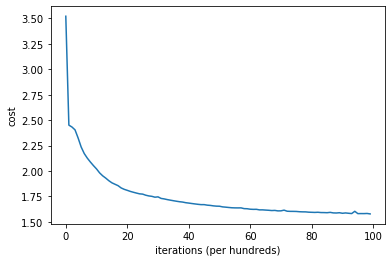

In [447]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')

plt.show()


In [448]:
pred=predict(parameters, X_train.T)
pred2=predict(parameters, X_test.T)

In [449]:
count=0
i=0
while i<1200:
    if(pred[i]==ytrain[i]):
        count=count+1
    i=i+1
print("train accuracy =",count/1200)

count=0
i=0
while i<300:
    if(pred2[i]==Y_test[i]):
        count=count+1
    i=i+1
print("test accuracy =",count/300)

train accuracy = 0.9141666666666667
test accuracy = 0.21333333333333335


In [451]:
lr = 0.01
parameters,costs = nn_model(X_train.T, Y_train.T, params, lr,  num_iterations = 10000, print_cost=True, optmethod = 1, beta = 0.9)

cost  3.521494851423584
cost  2.513178807401612
cost  2.4991405953767822
cost  2.48938673104759
cost  2.4820701882099225
cost  2.4765760243280055
cost  2.472504648471662
cost  2.4695082346793753
cost  2.467288033086858
cost  2.465609439436616


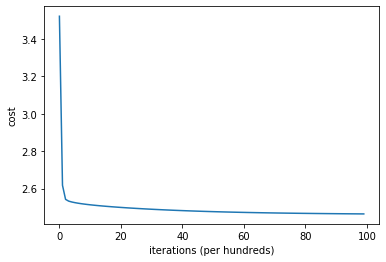

In [452]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')

plt.show()


In [453]:
pred=predict(parameters, X_train.T)
pred2=predict(parameters, X_test.T)

In [454]:
count=0
i=0
while i<1200:
    if(pred[i]==ytrain[i]):
        count=count+1
    i=i+1
print("train accuracy =",count/1200)

count=0
i=0
while i<300:
    if(pred2[i]==Y_test[i]):
        count=count+1
    i=i+1
print("test accuracy =",count/300)

train accuracy = 0.28833333333333333
test accuracy = 0.17666666666666667


In [456]:
lr = 0.01
parameters,costs = nn_model(X_train.T, Y_train.T, params, lr,  num_iterations = 10000, print_cost=True)

cost  3.521494851423584
cost  2.5131662643883605
cost  2.4991076748052885
cost  2.4893507606248164
cost  2.4820434112454826
cost  2.4765625679840433
cost  2.472503666623642
cost  2.4695170023784554
cost  2.4673037763282606
cost  2.4656300065313377


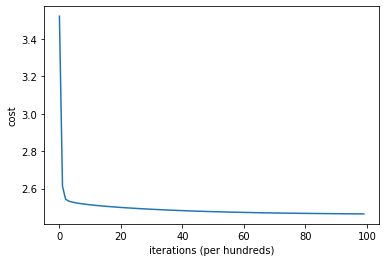

In [457]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')

plt.show()


In [458]:
pred=predict(parameters, X_train.T)
pred2=predict(parameters, X_test.T)

In [459]:
count=0
i=0
while i<1200:
    if(pred[i]==ytrain[i]):
        count=count+1
    i=i+1
print("train accuracy =",count/1200)

count=0
i=0
while i<300:
    if(pred2[i]==Y_test[i]):
        count=count+1
    i=i+1
print("test accuracy =",count/300)

train accuracy = 0.2875
test accuracy = 0.17666666666666667
